In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
import pygmt

In [2]:
def mogi(north_centre, east_centre, depth, delta_volume, northing, easting, plook):
    '''
    Calculates the range change for a Mogi source model
    
    Args: 
          north_centre : north coordinates of center of source (km)
          east_centre  : east coordinates of center of source (km)
          depth        : depth of the source (km)
          delta_volume : volume change of Mogi source (km^3)
          northing     : north coordinates of surface points (km)
          easting      : east coordinates of surface points (km)
          plook        : look vector of the satellite
    
    Returns:
          delta_range  : north coord's of points to calculate range change
          
          
    modified from the matlab version of T.Wright (rngchn_mogi.m)
    '''
    # coefficient for pressure
    displacement_coefficient = (1e6*delta_volume*3)/(np.pi*4)
    
    # distance matrix from the source location
    distance_mat = np.sqrt(np.square(northing-north_centre) + np.square(easting-east_centre))
    
    tmp_hyp = np.power(np.square(distance_mat) + np.square(depth),1.5)
    
    # horizontal displacement
    horizontal_displacement = displacement_coefficient * distance_mat / tmp_hyp
    
    # vertical displacement
    vertical_displacement = displacement_coefficient * depth / tmp_hyp
    
    # azimuthal angle
    azimuth = np.arctan2((easting-east_centre), (northing-north_centre))
    
    # north and east displacement from horizontal displacement and azimuth angle
    east_displacement = np.sin(azimuth) * horizontal_displacement
    north_displacement = np.cos(azimuth) * horizontal_displacement
    
    
    # projection of displacement field onto look vector
    displacement_vec = np.concatenate((east_displacement, north_displacement, vertical_displacement), axis=1)
    delta_range = displacement_vec.dot(np.transpose([plook]))
    delta_range = -1.0 * delta_range
    
    return delta_range

In [3]:
def extents(vector_component):
        delta = vector_component[1] - vector_component[0]
        return [vector_component[0] - delta/2, vector_component[-1] + delta/2]

### InSAR Line of sight

In [4]:
# the look angle measured from the nadir direction
look_angle = 23.

# the satellite track angle measured clockwise from geographic north.
track_angle   = -13.

track = np.deg2rad(track_angle)
look  = np.deg2rad(look_angle)

plook = [-np.sin(look)*np.cos(track), np.sin(look)*np.sin(track), np.cos(look)]

### Source parameters

In [5]:

source={'depth':2.58,
       'volume':0.0034,
        'east':18,
        'north':20
       }

### Surface grid

In [6]:
dimEasting     = 1100
dimNorthing    = 980
spacing        = 40

# Easting/Northing with respect to the centre
easting = np.arange(0,dimEasting*spacing,spacing) / 1e3
northing = np.arange(0,dimNorthing*spacing,spacing) / 1e3

# Grid northing/easting
northing_mat,easting_mat = np.meshgrid(northing,easting)

# Grid in 1D arrays
northing_vec = np.reshape(northing_mat, (dimEasting*dimNorthing, 1))
easting_vec = np.reshape(easting_mat, (dimEasting*dimNorthing, 1))

### Forward model 

In [7]:
calc_range = mogi(source['east'],source['north'], source['depth'], source['volume'],
                  northing_vec, easting_vec, plook)

surface_deformation = np.reshape(calc_range, (dimEasting,dimNorthing))
model = np.transpose(np.fliplr(surface_deformation))

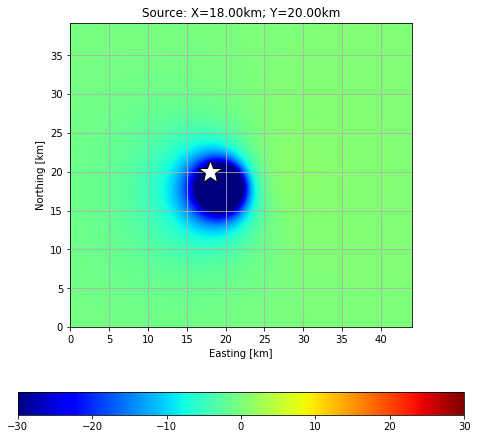

In [8]:
# Calculate the bounding box
extent_xvec = extents((np.arange(1, dimEasting*spacing, spacing)) / 1000)
extent_yvec = extents((np.arange(1, dimNorthing*spacing, spacing)) / 1000)
extent_xy = extent_xvec + extent_yvec

fig = plt.figure(figsize=(8, 8))
cmap = plt.cm.get_cmap("jet")
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(model, cmap=cmap, extent=extent_xy)
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
plt.grid()
im.set_clim(-30, 30)
ax.plot(source['east'],source['north'], 'k*', markersize=25, markerfacecolor='w')
ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (source['east'], source['north']))
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()